# Pixels to Tabular Data
## Agricultural Statistical Analysis Use Case

Talk about pixels and tabular data.

The use case addressed in this tutorial is:  

* As an agriculture customer, I'd like to create an imagery pipeline that provides for trialing different fungicides by ordering Planet imagery within a single field (AOI), cutting the imagery into multiple field blocks, filtering based on cloud coverage within the blocks, and comparing values across blocks in two ways. First, comparison is performed by extracting median, mean, variance NDVI values for each day (using random point sampling) in each block. Second, comparison is performed by random point selection in each block.


## Introduction

Two things are interesting about this use case. First, we are gridding the AOI into blocks. Second, we are performing some calculations with the output to compare results across different blocks in the field. 


## Implementation

For this use case, the area of interest and time range are not specified. The analytic comparison across blocks means we should specify a strict usable pixel data filter. For time-series analysis the daily coverage of PS satellites is ideal. We are just looking at a field, so we don't need to composite across scenes. This makes our lives easier as we don't need to group the scene ids by date, like we did in Part 2. We are, however, wanting to grid the field. We can use the Orders API to help us with this! And finally, we will need to implement a bit of functionality for the comparisons across the field blocks.

**TODO** UPDATE
To summarize, these are the steps:
1. Part 1: Get Field NDVI
 1. [Initialize API client](#Step-1:-Initialize-API-client)
 1. [Search Data API](#Step-2:-Search-Data-API)
 1. [Group IDs by Date](#Step-3:-Group-IDs-by-Date)
 1. [Submit Orders](#Step-4:-Submit-Orders)
 1. [Download Orders](#Step-5:-Download-Orders)
 1. [Unzip and Verify Orders](#Step-6:-Unzip-and-Verify-Orders)
1. Part 2: Sample Field Blocks





### Part 1: Setup

#### Import Dependencies

In [66]:
# from copy import copy
import datetime
import json
import os
from pathlib import Path
from pprint import pprint
import shutil
import time
from zipfile import ZipFile

import numpy as np
from planet import api
from planet.api import downloader, filters
from shapely.geometry import shape

#### Get Field and Sample Blocks AOIs

In [ ]:
def load_geojson(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [383]:
# this feature comes from within the sacramento_crops aoi
# it is the first feature in 'ground-truth-test.geojson', which
# was prepared in crop-classification/datasets-prepare.ipynb
field_filename = os.path.join('pre-data', 'field.geojson')
field = load_geojson(field_filename)
pprint(field)

{'geometry': {'coordinates': [[[-121.26311573121106, 38.28911976564886],
                               [-121.26309824204209, 38.289263573446426],
                               [-121.26340336500914, 38.28927552343227],
                               [-121.26341580611164, 38.28958419507872],
                               [-121.26335908094813, 38.290060214043095],
                               [-121.2633553819847, 38.29021303818384],
                               [-121.26200888330872, 38.2901989348931],
                               [-121.26202642045222, 38.28924931063856],
                               [-121.26202881277432, 38.28911976564886],
                               [-121.26311573121106, 38.28911976564886]]],
              'type': 'Polygon'},
 'id': '10906',
 'properties': {'ACRES': 5.382,
                'AREA': 21779.33318,
                'BL_X': 651939,
                'BL_Y': 4239347,
                'CLASS1': 'G',
                'CLASS2': '**',
                'CLAS

5.382 acres


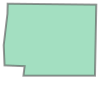

In [382]:
print('{} acres'.format(field['properties']['ACRES']))
field_aoi = field['geometry']
shape(field_aoi)

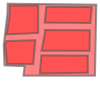

In [386]:
blocks = load_geojson(os.path.join('pre-data', 'blocks.geojson'))
block_aois = [b['geometry'] for b in blocks]

# visualize field and sample blocks
MultiPolygon([shape(a) for a in [field_aoi] + block_aois])

### Part 2: Get Field NDVI

#### Step 1: Search Data API

The goal of this step is to get the scene ids that meet the search criteria for this use case.

In [ ]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

client = api.ClientV1(api_key=API_KEY)

In [172]:
# create an api request from the search specifications
# relax the cloud cover requirement as filtering will be done within the aoi
def build_request(aoi_geom, start_date, stop_date):
    '''build a data api search request for clear PSScene4Band imagery'''
    query = filters.and_filter(
        filters.geom_filter(aoi_geom),
#         filters.range_filter('clear_percent', gte=40),
        filters.date_range('acquired', gt=start_date),
        filters.date_range('acquired', lt=stop_date)
    )
    return filters.build_search_request(query, ['PSScene4Band'])

def search_data_api(request, client, limit=500):
    result = client.quick_search(request)
    
    # this returns a generator
    return result.items_iter(limit=limit)

In [173]:
# define test data for the filter
test_start_date = datetime.datetime(year=2019,month=4,day=1)
test_stop_date = datetime.datetime(year=2019,month=5,day=1)

In [174]:
request = build_request(field_aoi, test_start_date, test_stop_date)
print(request)

{'item_types': ['PSScene4Band'], 'filter': {'type': 'AndFilter', 'config': ({'field_name': 'geometry', 'type': 'GeometryFilter', 'config': {'type': 'Polygon', 'coordinates': [[[-121.26311573121106, 38.28911976564886], [-121.26309824204209, 38.289263573446426], [-121.26340336500914, 38.28927552343227], [-121.26341580611164, 38.28958419507872], [-121.26335908094813, 38.290060214043095], [-121.2633553819847, 38.29021303818384], [-121.26200888330872, 38.2901989348931], [-121.26202642045222, 38.28924931063856], [-121.26202881277432, 38.28911976564886], [-121.26311573121106, 38.28911976564886]]]}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'gt': '2019-04-01T00:00:00Z'}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'lt': '2019-05-01T00:00:00Z'}})}}


In [175]:
items = list(search_data_api(request, client))
print(len(items))

33


In [176]:
pprint(items[0])

{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20190409_185936_13_106c',
            'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20190409_185936_13_106c/assets/',
            'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20190409_185936_13_106c/thumb'},
 '_permissions': ['assets.udm:download',
                  'assets.analytic:download',
                  'assets.analytic_xml:download',
                  'assets.analytic_dn:download',
                  'assets.analytic_dn_xml:download',
                  'assets.basic_analytic:download',
                  'assets.basic_analytic_rpc:download',
                  'assets.basic_analytic_dn:download',
                  'assets.basic_analytic_dn_rpc:download',
                  'assets.basic_analytic_xml:download',
                  'assets.basic_analytic_dn_xml:download',
                  'assets.basic_analytic_dn_nitf:download',
               

In [177]:
# visualize a footprint
footprints = [shape(i['geometry']) for i in items]

In [178]:
# make sure all footprints contain the field aoi (that is, no partial overlaps)
for f in footprints:
    assert f.contains(shape(field_aoi))

In [179]:
from shapely.geometry import MultiPolygon

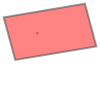

In [180]:
# visualize aoi and footprint
MultiPolygon([shape(field_aoi), footprints[0]])

Whoa look! That AOI is tiny relative to the image footprint. We don't want to wrangle all those pixels outside of the AOI. We definately want to clip the imagery footprints to the AOI.

#### Step 2: Submit Order

Now that we have the scene ids, we can create the order. The output of this step is a single zip file that contains all of the scenes that meet our criteria.

The tools we want to apply are: clip imagery to AOI, convert imagery to NDVI, and reproject all imagery to the same projection. 

##### Step 2.1: Define Toolchain Tools

In this step, we clip the imagery to the AOI and convert the imagery to NDVI.

Why do we clip the imagery to the AOI? As we just saw, the imagery footprints are big, rectangular shapes. They cover the AOI but they do not match the AOI. Since we only care about pixels within the AOI, we clip the footprints to that AOI.

In [181]:
def get_tools(aoi_geom):
    # clip to AOI
    clip_tool = {'clip': {'aoi': aoi_geom}}

    # convert to NDVI
    ndvi_tool = {'bandmath': {
        "pixel_type": "32R",
        "b1": "(b4 - b3) / (b4+b3)"
    }}

    tools = [clip_tool, ndvi_tool]
    return tools

##### Step 2.2: Build Order Requests

In [182]:
def build_order(ids, name, aoi_geom):
    # specify the psscene4band surface reflectance product
    # make sure to get the *_udm2 bundle so you get the udm2 product
    # note: capitalization really matters in item_type when using planet client orders api
    item_type = 'PSScene4Band'
    bundle = 'analytic_sr_udm2'

    orders_request = {
        'name': name,
        'products': [{
            'item_ids': ids,
            'item_type': item_type,
            'product_bundle': bundle
        }],
        'tools': get_tools(aoi_geom),
        'delivery': {
            'single_archive': True,
            'archive_filename':'{{name}}_{{order_id}}.zip',
            'archive_type':'zip'
        },
            'notifications': {
                       'email': False
        },
    }
    return orders_request
# uncomment to see what an order request would look like
# pprint(build_order(['id'], 'demo', test_aoi_geom), indent=4)

In [183]:
ids = [i['id'] for i in items]
name = 'pixels_to_tabular'

In [184]:
order_request = build_order(ids, name, field_aoi)

##### Step 2.3: Submit Order

In [215]:
def create_order(order_request, client):
    orders_info = client.create_order(order_request).get()
    return orders_info['id']

order_id = create_order(order_request, client)
order_id

'e3a16e9f-a933-4717-a491-ed7ca0495a3d'

#### Step 3: Download Orders

##### Step 3.1: Wait Until Orders are Successful

Before we can download the orders, they have to be prepared on the server.

In [218]:
def poll_for_success(order_id, client, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1
        order_info = client.get_individual_order(order_id).get()
        state = order_info['state']
        print(state)
        success_states = ['success', 'partial']
        if state == 'failed':
            raise Exception(response)
        elif state in success_states:
            break
        
        time.sleep(10)
        
poll_for_success(order_id, client)

success


##### Step 3.2: Run Download

For this step we will use the planet python orders API because the CLI doesn't do a complete download with large orders.

In [219]:
data_dir = os.path.join('data', 'field_statistical_analysis')

# make the download directory if it doesn't exist
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [225]:
def poll_for_download(dest, endswith, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1        
        matched_files = (f for f in os.listdir(dest)
                         if os.path.isfile(os.path.join(dest, f))
                         and f.endswith(endswith))

        match = next(matched_files, None)
        if match:
            match = os.path.join(dest, match)
            print('downloaded')
            break
        else:
            print('waiting...')
        time.sleep(10)
    return match

def download_order(order_id, dest, client, limit=None):
    '''Download an order by given order ID'''
    # this returns download stats but they aren't accurate or informative
    # so we will look for the downloaded file on our own.
    dl = downloader.create(client, order=True)
    urls = client.get_individual_order(order_id).items_iter(limit=limit)
    dl.download(urls, [], dest)
    
    endswith = '{}.zip'.format(order_id)
    filename = poll_for_download(dest, endswith)
    return filename

downloaded_file = download_order(order_id, data_dir, client)

downloaded


In [226]:
downloaded_file

'data/field_statistical_analysis/pixels_to_tabular_e3a16e9f-a933-4717-a491-ed7ca0495a3d.zip'

#### Step 4: Unzip Order

In this section, we will unzip the order into a directory named after the downloaded zip file.

In [227]:
def unzip(filename, overwrite=False):
    location = Path(filename)
    zipdir = location.parent / location.stem

    if os.path.isdir(zipdir):
        if overwrite:
            print('{} exists. overwriting.'.format(zipdir))
            shutil.rmtree(zipdir)
        else:
            raise Exception('{} already exists'.format(zipdir))
        
    with ZipFile(location) as myzip:
        myzip.extractall(zipdir)
    return zipdir

zipdir = unzip(downloaded_file)
zipdir

PosixPath('data/field_statistical_analysis/pixels_to_tabular_e3a16e9f-a933-4717-a491-ed7ca0495a3d')

In [228]:
def get_unzipped_files(zipdir):
    filedir = zipdir / 'files'
    filenames = os.listdir(filedir)
    return [filedir / f for f in filenames]

file_paths = get_unzipped_files(zipdir)
file_paths[0]

PosixPath('data/field_statistical_analysis/pixels_to_tabular_e3a16e9f-a933-4717-a491-ed7ca0495a3d/files/20190412_173508_1054_3B_AnalyticMS_DN_udm_clip.tif')

In [229]:
# we demonstrated visualization in the best practices tutorial
# here, we save space by just importing the functionality
from visual import show_ndvi

#### Step 5: Filter by Cloudiness

In this section, we will filter images that have any clouds within the AOI. We use the Unusable Data Mask (UDM2) to determine cloud pixels.

In [231]:
udm2_files = [f for f in file_paths if 'udm2' in str(f)]

In [232]:
from rasterio import plot

In [233]:
# we want to find pixels that are inside the footprint but cloudy
# the easiest way to do this is is the udm values (band 8)
# https://developers.planet.com/docs/data/udm-2/
# the UDM values are given in 
# https://assets.planet.com/docs/Combined-Imagery-Product-Spec-Dec-2018.pdf
# Bit 0: blackfill (footprint)
# Bit 1: cloud covered
def read_udm(udm2_filename):
    with rasterio.open(udm2_filename) as img:
        # band 8 is the udm band
        return img.read(8)

In [234]:
def get_cloudy_percent(udm_band):
    blackfill = udm_band == int('1', 2)
    footprint_count = udm_band.size - np.count_nonzero(blackfill)
    cloudy = udm_band.size - udm_band == int('10', 2)
    cloudy_count = np.count_nonzero(cloudy)
    return (cloudy_count / footprint_count)

get_cloudy_percent(read_udm(udm2_files[0]))

0.0

In [238]:
clear_udm2_files = [f for f in udm2_files
                    if get_cloudy_percent(read_udm(f)) < 0.00001]
print(len(clear_udm2_files))

33


In [248]:
def get_id(udm2_filename):
    return udm2_filename.name.split('_3B')[0]
    
clear_ids = [get_id(f) for f in clear_udm2_files]
clear_ids[0]

'20190403_182837_1002'

#### Step 6: Get Clear Images


In [266]:
# pprint([f for f in file_paths if 'udm2' in str(f)])

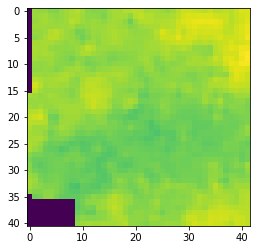

In [263]:
def get_img_path(img_id, file_paths):
    filename = '{}_3B_AnalyticMS_SR_clip_bandmath.tif'.format(img_id)
    return next(f for f in file_paths if f.name == filename)

def read_ndvi(img_filename):
    with rasterio.open(img_filename) as img:
        # ndvi is a single-band image
        band = img.read(1)
    return band

plot.show(read_img(get_img_path(clear_ids[0], file_paths)))

The field AOI isn't an exact square so there are some blank pixels. Let's mask those out. We can use the UDM for that.

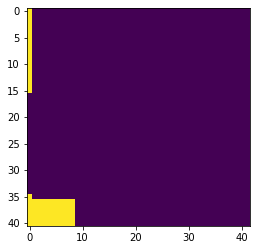

In [272]:
def get_udm2_path(img_id, file_paths):
    filename = '{}_3B_udm2_clip.tif'.format(img_id)
    return next(f for f in file_paths if f.name == filename)
    
def read_blackfill(udm2_filename):
    with rasterio.open(udm2_filename) as img:
        # the last band is the udm band
        udm_band = img.read(8)
    blackfill = udm_band == int('1', 2)
    return blackfill

plot.show(read_blackfill(get_udm2_path(clear_ids[0], file_paths)))

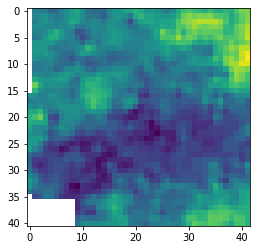

In [275]:
# there is an issue where some udms aren't the same size as the images
# to deal with this just cut off any trailing rows/columns
# this isn't ideal as it can result in up to one pixel shift in x or y direction
def crop(img, shape):
    return img[:shape[0], :shape[1]]

def read_masked_ndvi(img_filename, udm2_filename):
    ndvi = read_ndvi(img_filename)
    blackfill = read_blackfill(udm2_filename)
        
    # crop image and mask to same size
    img_shape = min(ndvi.shape, blackfill.shape)
    ndvi = np.ma.array(crop(ndvi, img_shape), mask=crop(blackfill, img_shape))
    return ndvi

plot.show(read_masked_ndvi(get_img_path(clear_ids[0], file_paths),
                           get_udm2_path(clear_ids[0], file_paths)))

That looks better! We now have the NDVI values for the pixels within the field AOI.

Now, lets make that a little easier to generate.

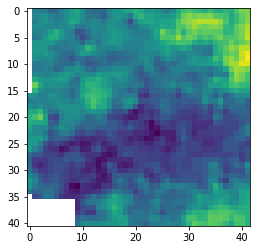

In [284]:
def read_masked_ndvi_by_id(iid, file_paths):
    return read_masked_ndvi(get_img_path(iid, file_paths), get_udm2_path(iid, file_paths))

plot.show(read_masked_ndvi_by_id(clear_ids[0], file_paths))

### Part 3: Sample Field Blocks

#### Step 1: Get Field Block Pixels

To get the field block pixels we have to project the block geometries into the image coordinates

In [421]:
def read_crs(img):
    with rasterio.open(img) as src:
        return src.crs
    
dst_crs = read_crs(get_img_path(clear_ids[0], file_paths))
dst_crs

CRS.from_epsg(32610)

In [423]:
import pyproj
from shapely.ops import transform

wgs84 = pyproj.CRS('EPSG:4326')

project = pyproj.Transformer.from_crs(wgs84, dst_crs, always_xy=True).transform
proj_block_aois = [transform(project, shape(b)) for b in block_aois]

In [389]:
from rasterio.features import geometry_mask

In [392]:
block_aois[0]

{'type': 'Polygon',
 'coordinates': [[[-121.26332402229309, 38.290185014278734],
   [-121.26332402229309, 38.29004396446891],
   [-121.26337230205536, 38.289747127406486],
   [-121.2628921866417, 38.289768179720404],
   [-121.2628921866417, 38.290185014278734],
   [-121.26332402229309, 38.290185014278734]]]}

In [409]:
from rasterio.mask import raster_geometry_mask

In [441]:
with rasterio.open(img) as dset:
    masks = [raster_geometry_mask(dset, [b], crop=False)[0]
             for b in proj_block_aois]

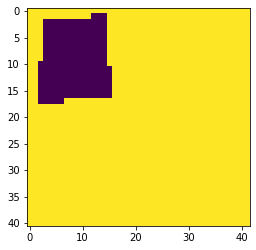

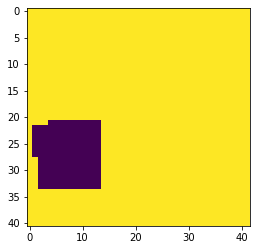

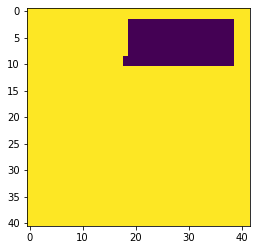

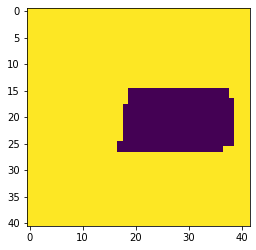

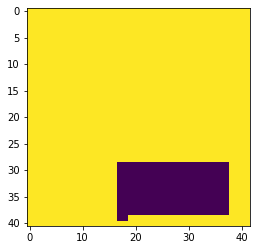

In [443]:
for m in masks:
    plot.show(m)

#### Step 2: Random Sampling

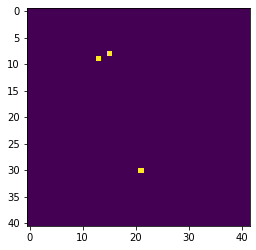

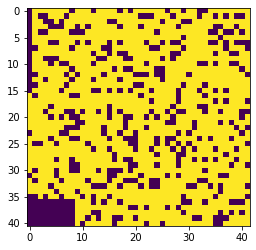

In [351]:
np.random.seed(0) # 0 - make random sampling repeatable, none - nonrepeatable

def random_mask_sample(mask, count):
    # get shape of unmasked pixels
    unmasked = mask == False
    unmasked_shape = mask[unmasked].shape
    
    # uniformly sample pixel indices
    num_unmasked = unmasked_shape[0]
    idx = np.random.choice(num_unmasked, count, replace=False)
#     print(idx)
    
    # assign uniformly sampled indices to True
    random_mask = np.zeros(unmasked_shape, dtype=np.bool)
    random_mask[idx] = True
#     print(random_mask.shape)
    
    # reshape back to image shape and account for image mask
    random_sample_mask = np.zeros(mask.shape, dtype=np.bool)
    random_sample_mask[unmasked] = random_mask
    return random_sample_mask


# lets just check out how our random sampling performs
plot.show(random_mask_sample(read_masked_ndvi_by_id(clear_ids[0], file_paths).mask, 3))
plot.show(random_mask_sample(read_masked_ndvi_by_id(clear_ids[0], file_paths).mask, 1300))

Ok, great! The first image shows what would result from sampling 30 pixels. The second image just demonstrates that the mask is taken into account with sampling.

Now lets define the field blocks and go on our merry way.



In [295]:
read_masked_ndvi(get_img_path(clear_ids[0], file_paths),
                           get_udm2_path(clear_ids[0], file_paths)).shape

(41, 42)

In [281]:
41*42

1722

In [ ]:
np.random.choice(5, 3)